In [1]:
import pandas as pd
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
station_path = "../data/interim/dot_traffic_station_2015.csv"
traffic_path = "../data/interim/dot_traffic_2015.csv"

In [3]:
traffic_df = pd.read_csv(traffic_path)
station_df = pd.read_csv(station_path)

# EDA

Lets do some EDA on the respective df to see if we can generate any informative insights from them. Since we are trying to predict traffic volume for the New York's rush hour

## Station

In [23]:
station_df.loc[station_df["fips_state_code"] == 6]

,algorithm_of_vehicle_classification,calibration_of_weighing_system,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel_name,fips_county_code,fips_state_code,functional_classification_name,hpms_sample_identifier,...,sample_type_for_truck_weight,sample_type_for_vehicle_classification,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,13,3,091,West,59,6,Urban: Principal Arterial - Other Freeways or ...,NaN,...,NaN,0,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,Inductance loop,15,0,97
1,NaN,NaN,13,3,099,South,77,6,Rural: Principal Arterial - Other,NaN,...,NaN,0,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,Inductance loop,15,0,97
2,G,NaN,15,1,005,North,93,6,Rural: Principal Arterial - Interstate,NaN,...,NaN,1,N,NaN,022940,EDGEWOOD SIS5R22.999,Piezoelectric,15,0,69
13,G,NaN,15,3,098,East,25,6,Rural: Minor Arterial,NaN,...,NaN,1,N,NaN,116670,CALEXICO JCT RTE 7 IMP9839.56,Piezoelectric,15,0,98
18,NaN,NaN,13,1,015,South,73,6,Urban: Principal Arterial - Other Freeways or ...,NaN,...,NaN,0,N,NaN,119100,JCT. RTE. 805 SD15R3.367,Inductance loop,15,0,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28427,G,NaN,15,3,065,North,107,6,Urban: Principal Arterial - Other Freeways or ...,NaN,...,NaN,1,N,NaN,066320,AVENUE 184 TUL6523.333,Piezoelectric,15,0,97
28436,NaN,NaN,13,1,005,North,37,6,Urban: Principal Arterial - Interstate,NaN,...,NaN,0,N,NaN,074550,S/O JCT RTE 210; N/O LA543,Inductance loop,15,0,97
28437,G,C,15,3,091,East,37,6,Urban: Principal Arterial - Other Freeways or ...,NaN,...,T,1,P,NaN,079040,ARTESIA LA0917.5,Bending plate,15,0,97
28451,NaN,NaN,13,1,405,South,37,6,Urban: Principal Arterial - Interstate,NaN,...,NaN,0,N,NaN,074650,N/O LAKEWOOD BL; REDONDO LA405,Inductance loop,15,0,97


In [6]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28466 entries, 0 to 28465
Data columns (total 41 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   algorithm_of_vehicle_classification               18576 non-null  object 
 1   calibration_of_weighing_system                    8165 non-null   object 
 2   classification_system_for_vehicle_classification  28466 non-null  int64  
 3   concurrent_route_signing                          28466 non-null  int64  
 4   concurrent_signed_route_number                    13592 non-null  object 
 5   direction_of_travel_name                          28466 non-null  object 
 6   fips_county_code                                  28466 non-null  int64  
 7   fips_state_code                                   28466 non-null  int64  
 8   functional_classification_name                    28466 non-null  object 
 9   hpms_sample_ident

Firstly, we would do some EDA on columns with missing value to determine if there's a way to intelligently fill in the missing values

Since this column have to do with the weighing system, let's compare the relationship of this column with the various weight-related columns in this dataframe.

Mapping Table:

1. nan maps to []
2. M maps to ['Moving average of the steering axle of 3S2s']
3. 0 maps to [nan]
4. Z maps to ['Other method']
5. T maps to ['Test trucks only']
6. C maps to ['Combination of test trucks and trucks from the traffic stream (but not ASTM E1318)']
7. A maps to ['ASTM Standard E1318']
8. U maps to ['Uncalibrated']
9. D maps to ['Other sample of trucks from the traffic stream']
10. P maps to [nan]
11. 2 maps to [nan]
12. B maps to ['Subset of ASTM Standard E1318']
13. S maps to ['Static calibration']

In [4]:
station_df["method_of_truck_weighing_name"]

0                                       0
1                                       0
2                                       0
3         Portable weigh-in-motion system
4                                       0
                       ...               
28461                                   0
28462                                   0
28463                                   0
28464    Permanent weigh-in-motion system
28465                                   0
Name: method_of_truck_weighing_name, Length: 28466, dtype: object

In [5]:
station_df["sample_type_for_truck_weight"].value_counts()

N    9528
T    5136
B     920
0     739
L      70
5      10
1       1
Name: sample_type_for_truck_weight, dtype: int64

In [6]:
station_df["sample_type_for_traffic_volume"].value_counts()

1    26426
0     2040
Name: sample_type_for_traffic_volume, dtype: int64

## Traffic Data

In [7]:
traffic_df["record_type"].unique()

array([3], dtype=int64)

All the rows in the record_type column are 3, which does will not help the model in its prediction

In [8]:
traffic_df.drop("record_type", axis=1, inplace=True)

In [9]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140391 entries, 0 to 7140390
Data columns (total 34 columns):
 #   Column                                     Dtype 
---  ------                                     ----- 
 0   date                                       object
 1   day_of_data                                int64 
 2   day_of_week                                int64 
 3   direction_of_travel_name                   object
 4   fips_state_code                            int64 
 5   functional_classification_name             object
 6   lane_of_travel                             int64 
 7   month_of_data                              int64 
 8   station_id                                 object
 9   traffic_volume_counted_after_0000_to_0100  int64 
 10  traffic_volume_counted_after_0100_to_0200  int64 
 11  traffic_volume_counted_after_0200_to_0300  int64 
 12  traffic_volume_counted_after_0300_to_0400  int64 
 13  traffic_volume_counted_after_0400_to_0500  int64 
 14  tr

### Day of Week Seasonality Trend

In [12]:
volume_columns = [column for column in traffic_df.columns if column.startswith("traffic_volume")]
traffic_df["total_volume"] = traffic_df[volume_columns].sum(axis=1)

In [15]:
day_groupby = traffic_df.groupby("day_of_week").sum()["total_volume"]

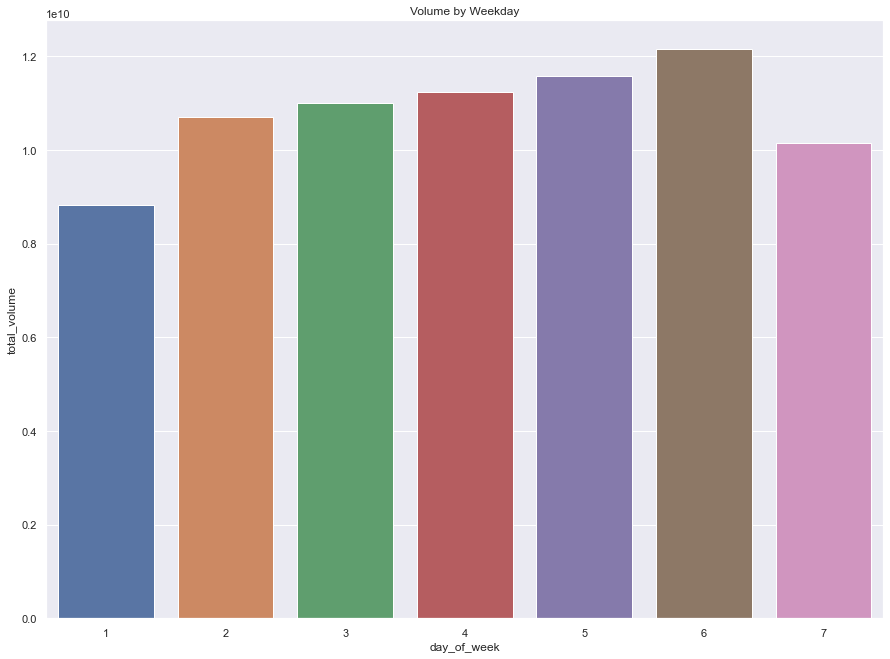

In [16]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by Weekday")
sns.barplot(x=day_groupby.index, y=day_groupby, ax=ax)
plt.show()

We will assume for this dataset that day_7 is Sunday and day_1 is Monday, so on and so forth.

Based on the traffic volume, we can see that other than Monday, all the other week days have the highest volume of traffic. This could be due to people commuting to work.

### Month Seasonality Trend

In [17]:
month_groupby = traffic_df.groupby("month_of_data").sum()["total_volume"]

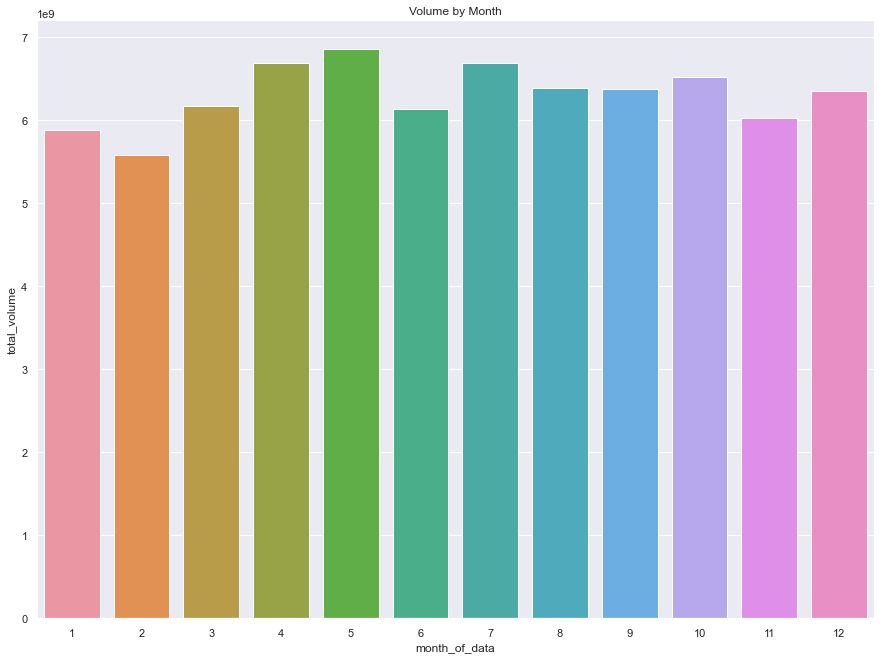

In [18]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by Month")
sns.barplot(x=month_groupby.index, y=month_groupby, ax=ax)
plt.show()

The volume across months seems to be fairly consistent however

### Hourly Seasonality Trend

In [ ]:
volume_columns

In [ ]:
hourly_groupby = traffic_df[volume_columns].sum()

In [11]:
hourly_groupby.index

NameError: name 'hourly_groupby' is not defined

In [148]:
# rename column for clarity
for column in volume_columns:
    name = column.split("_")[4]
    hourly_groupby = hourly_groupby.rename(index={column: name})
    

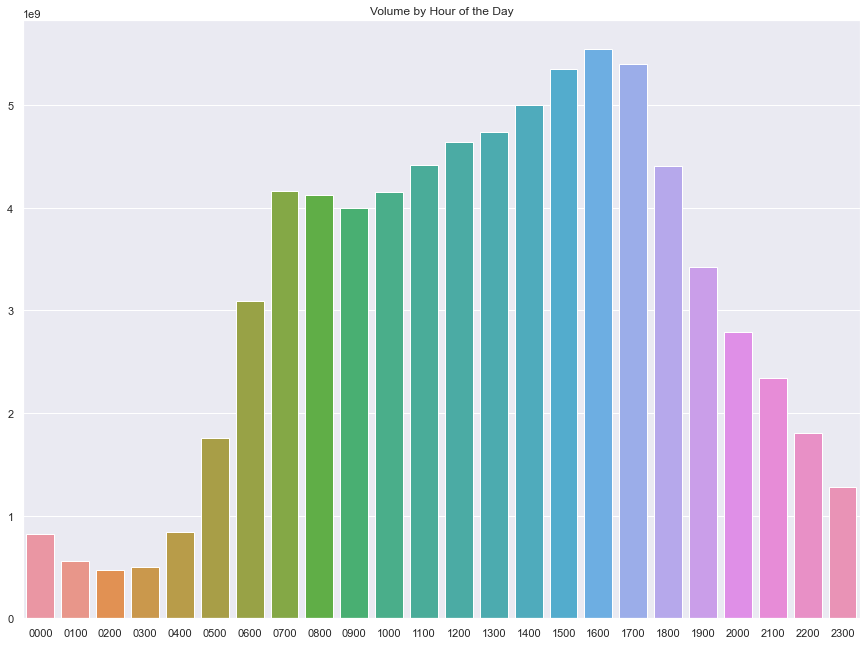

In [150]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by Hour of the Day")
sns.barplot(x=hourly_groupby.index, y=hourly_groupby, ax=ax)
plt.show()

Not surprisingly, odd hours such as 10pm to 5am have the lowest traffic volume among all the hours of the day. Volume starts to spike at around 6am as people start commuting to their workplace and delivery fleets start their day. Traffic volume increase continuously throughout the day until around 5pm to 6pm when it starts declining as people start to knock off and commute home where they rest and stop travelling on roads.

Based on Wikipedia, rush hour is typically between 6am to 10am (morning) and 3pm to 7pm (evening) which seems to agree with this plot where traffic volume is typically at its highest.

### Lane of Travel

Lane of travel is in int dtype when it is actually a mapping, converting it back to category for visualisation purposes

In [167]:
traffic_df["lane_of_travel"] = traffic_df["lane_of_travel"].astype("object")

In [179]:
lane_of_travel_groupby = traffic_df.groupby("lane_of_travel").sum()
lane_of_travel_groupby.reset_index(inplace=True)

In [184]:
lane_of_travel_groupby[volume_columns]

,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,...,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400
0,409241065,283237751,242848563,258293211,446141765,924475389,1555707525,2051221048,2054480518,1984637406,...,2447522244,2591259471,2664592828,2606710854,2155178790,1679429144,1369726313,1152389915,891592168,622107095
1,181021995,128836205,109333386,116209748,178921731,350067788,620011920,863507478,865070868,865018865,...,1081766728,1156556979,1201250945,1164349052,944592208,739468658,608607048,506586191,392150118,287087011
2,136694945,92755784,75823831,78665422,125907517,269362776,508629951,704817880,683767881,668925275,...,867511676,938562396,982244618,949503317,756730810,584623635,475508334,396229136,305705863,221199766
3,59828251,37903578,29551416,30898855,54240830,128593394,257894656,350655262,335156489,310579194,...,395308174,432928365,455479210,443159869,355834040,271029874,218019530,183412771,142398334,100324864
4,21239867,13290552,10452898,11505163,21353080,52767275,103399674,134479611,126927082,115865731,...,145695605,160395612,168334528,163341823,132431761,99990283,79360545,67586447,52481618,36303902
5,7471537,4666455,3661219,4158483,7847325,18837595,32824129,41730004,40552961,37836246,...,46409830,50281330,52779941,51422793,43021563,33410612,26665498,22568887,17976427,12271683
6,2139412,1233533,915222,967508,1826695,6334340,12844010,14940540,13848005,12971365,...,16592646,18390090,18633161,18566366,16108877,11995238,9086513,7534907,5847949,3775304
7,426546,262586,210716,205924,371534,1561284,3043298,3578059,3194005,2690620,...,3308745,3668706,3885582,3893052,3138430,2243524,1763733,1480691,1170194,749030
8,136722,86932,74692,74787,136080,295840,499993,625905,556237,584518,...,1161017,1199023,1163733,1113059,944292,730893,597334,502877,367844,233845
9,1613,889,666,602,1042,2685,5040,4755,4860,5500,...,12522,23188,31372,28658,12352,7619,5920,5225,3793,2625


<AxesSubplot:xlabel='lane_of_travel', ylabel='traffic_volume_counted_after_0000_to_0100'>

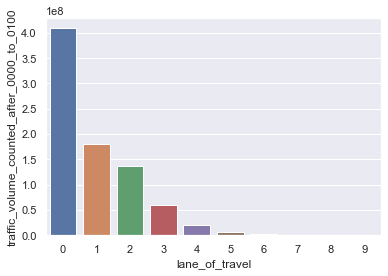

In [186]:
sns.barplot(y="traffic_volume_counted_after_0000_to_0100", x="lane_of_travel", data=lane_of_travel_groupby)

## Feature Engineering

Some interesting features we can engineer from this dataset could be the total traffic volume in a day. This could be useful when we are trying to determine if there's any seasonality based on months

In [78]:
volume_columns = [column for column in traffic_df.columns if column.startswith("traffic_volume")]
traffic_df["total_volume"] = traffic_df[volume_columns].sum(axis=1)